In [1]:
#pip install python_speech_features

In [2]:
#pip install h5py

In [3]:
#pip install librosa

In [18]:
#pip install import-ipyn

In [86]:
import os
from python_speech_features import mfcc, logfbank
import librosa
from scipy.io import wavfile

from tqdm import tqdm
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from keras.layers import Conv2D, MaxPool2D, Flatten,LSTM 
from keras.layers import Dropout , Dense , TimeDistributed
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.model_selection import train_test_split 


**Objectif :**

construire un système de classification d’audio automatique généraliste pour identifier les instruments musicaux. 
**la motivation :**
La classification audio des instruments peut avoir de nombreuses utilisations dans différents domaines 
- La reconnaissance musicale : Les systèmes de reconnaissance musicale automatique utilisent souvent la classification des instruments pour identifier les instruments présents dans une chanson ou une pièce musicale.
- La production audio : Les ingénieurs du son et les producteurs utilisent souvent des systèmes de classification des instruments pour aider à traiter les pistes audios d'une chanson ou d'un album.
- La reconnaissance de la parole : La classification des instruments peut également être utilisée pour améliorer la reconnaissance de la parole en éliminant les bruits d'arrière-plan indésirables, tels que les sons d'instruments, qui peuvent interférer avec la compréhension de la parole.

**Dataset :**

Freesound plus de 370 000 avec plus de 40 labels
https://www.kaggle.com/c/freesound-audio-tagging



In [213]:
input_path="C:/Users/nourl/Desktop/"
output_path="C:/Users/nourl/Desktop/freesound-audio-tagging/output/"

In [214]:
#importer data 
def import_data(input_path):
    df=pd.read_csv(os.path.join(input_path,"freesound-audio-tagging/train.csv"))
    instruments=np.array(['Violin_or_fiddle', 'Acoustic_guitar', 'Double_bass', 'Bass_drum',
           'Flute', 'Snare_drum', 'Clarinet', 'Cello', 'Saxophone', 'Hi-hat'])


    #supprimer "manually_verified" qui est inutile
    df.drop(columns=['manually_verified'],inplace=True)
    #selectionner les labels des instruments seulements
    df=df[df["label"].isin(instruments)]
    df.reset_index(drop=True,inplace=True)
    #creer colonne longueur
    df["longueur"]=np.zeros(df.shape[0])
    for i in tqdm(range(df.shape[0])):
        #lire le fichier audio
        freq,signal=wavfile.read(os.path.join(input_path,'freesound-audio-tagging/audio_train/',df.loc[i,'fname']))
        #calculer la longueur en s qui corresponds au len(signal)(n) devisé par rate(n/seconde)
        df.loc[i,"longueur"]=signal.shape[0]/freq #longeur de signal en seconde
    return(df,instruments)



# 1) EXPLORATION DES DONNEES 

In [215]:
df,instruments=import_data(input_path)
print("nombre d'instrument (labels) :",instruments.shape)
#fname : le nom de fichier 
#label : l'étiquette de classification audio 
df.head(3)

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:03<00:00, 842.08it/s]

nombre d'instrument (labels) : (10,)


,fname,label,longueur
0,00044347.wav,Hi-hat,14.00
1,001ca53d.wav,Saxophone,10.32
2,00353774.wav,Cello,4.52


definitions:

**Frequence d'echantillionnage :**

la frequence d'echantillionnage est le nombre de d'echantillion par seconde.

Le standard CD et digital mondial est de 44 100 Hz.

La fréquence d’échantillonnage affecte la plage de fréquence audio:

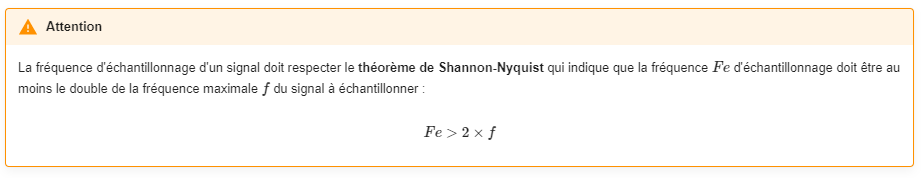

un taux d’échantillonnage donné peut enregistrer avec précision des fréquences audio jusqu’à un peu moins de la moitié de sa valeur cette limite de la moitié du taux d’échantillonnage s’appelle la fréquence de **Nyquist**

In [216]:
df.head(3)

,fname,label,longueur
0,00044347.wav,Hi-hat,14.00
1,001ca53d.wav,Saxophone,10.32
2,00353774.wav,Cello,4.52


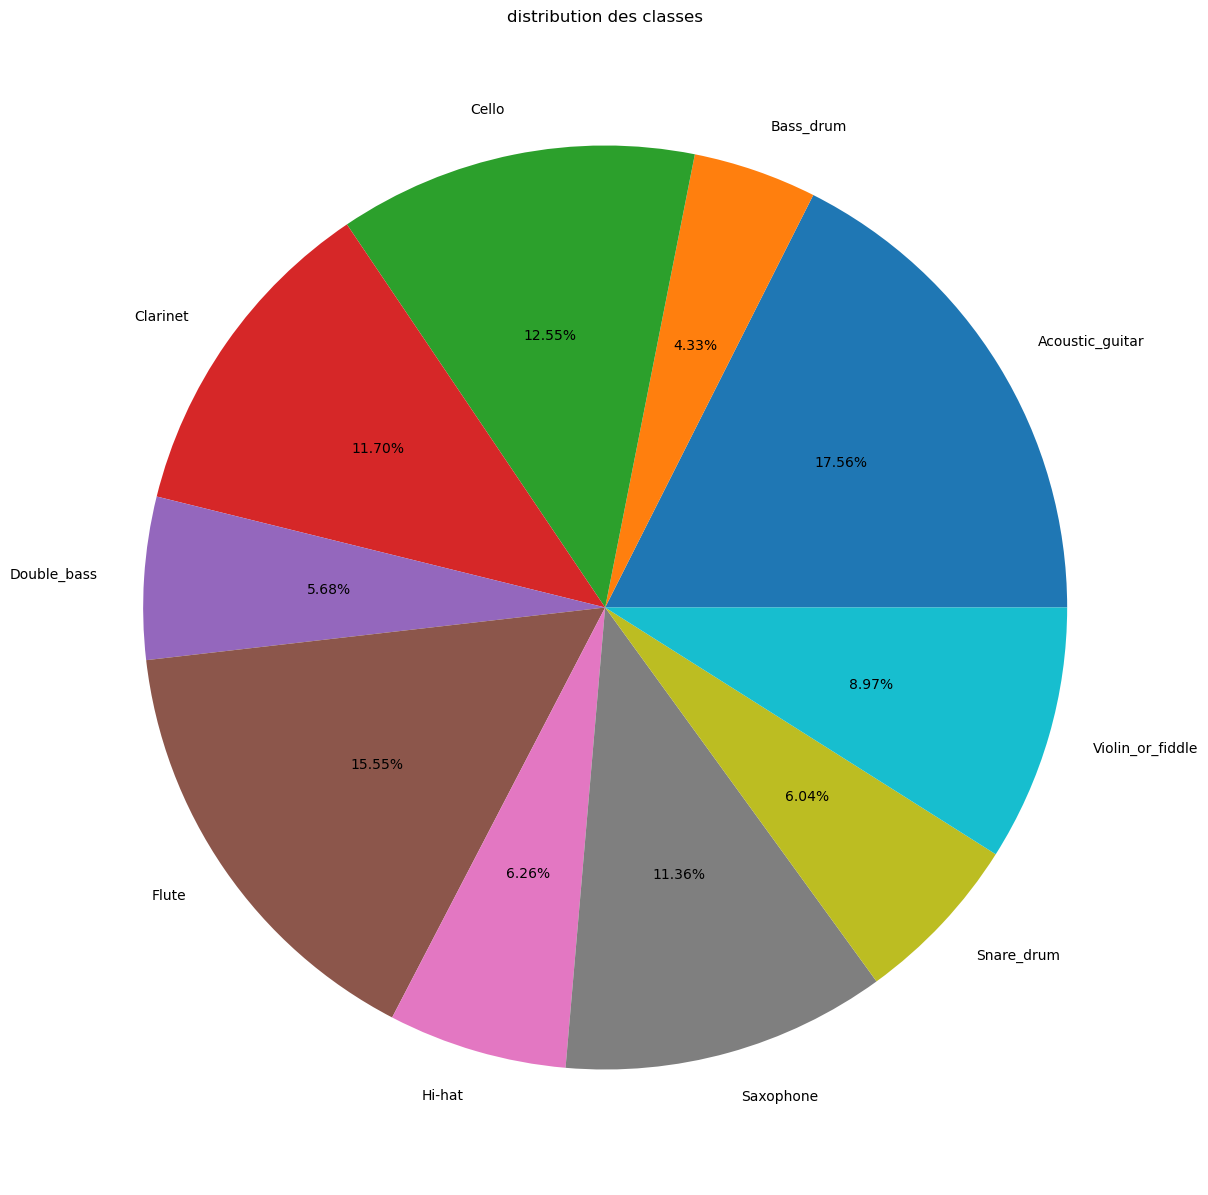

In [217]:
#distribution des labels dans les données 
label_dist=df.groupby(['label'])['longueur'].mean()
prob_dist=label_dist/label_dist.sum()
fig=plt.figure(figsize=(15,15))
plt.pie(label_dist,labels=prob_dist.index,autopct='%2.2f%%')
plt.title("distribution des classes")
plt.show()

# 2) Extraction des caractéristiques audio


### a) Enveloppe d'un signal 

L'enveloppe sonore est la courbe décrivant l'évolution d'une propriété d'un son
ici on va calculer la moyenne pour une fenetre de un dixieme de seconde et prendre seulement les amplitude ou la moyenne depasse une seuil alpha.
avec cela on obtient des courbes plus lisse et plus pertinent (sans bruit) 

In [218]:
def signal_envelope (signal,rate,alpha):
    #convertir to pandas serie
    y=pd.Series(signal).apply(np.abs)
    #calculer la moyenne pour une fenetre d'un dixeme de seconde
    y_moy=y.rolling(window=int(rate/10),min_periods=1,center=True).mean() 
    #selection ceux qui depasse la seuil alpha
    return(signal[y_moy>alpha])

### b) transformation de Fourier 

**definition** :
la transformation de fourier permet de representer le spectre des frequences d'un signal non periodiques.

**Remarque**:
on normalise notre signal par sa longueur pour garantir un equilibre 
car:
lorsque la longueur d'un signal augmante, une amplitude donnée a plus de chance de se repeter dans ce dernier 

In [219]:
def fft(signal,freq):
    n=signal.shape[0]
    # Fréquences de la transformée de Fourier
    f_freq=np.fft.rfftfreq(n,d=1/freq) 
    # Transformée de fourier
    f=abs(np.fft.rfft(signal)/n) 
    return (f,f_freq)

### c) Filter bank coefficients &  Mel cepstrum coefficients 

Les coefficients de filtre de bande sont une technique utilisée pour extraire des caractéristiques d'un signal audio. Il s'agit d'une méthode de transformation du signal qui permet de séparer un signal audio complet en plusieurs bandes de fréquences. Chacune de ces bandes est ensuite analysée séparément pour extraire des caractéristiques spécifiques. Les coefficients de filtre de bande sont souvent utilisés pour la reconnaissance de la parole, la reconnaissance musicale et la classification audio, car ils permettent de capturer les caractéristiques spectrales d'un signal audio qui sont souvent importantes pour ces tâches.
Les filtres utilisés pour séparer les fréquences sont généralement des filtres de Mel ou de Bark, qui sont des filtres basés sur les caractéristiques de l'oreille humaine. Ces filtres permettent de créer des bandes de fréquences qui sont plus proches de la façon dont l'oreille humaine perçoit les sons.

**entrée:** signal audio (np.array)

**retourne:** un tableau ou chaque ligne contient un vecteur de caractéristiques

Tous les échantillons audio de cet ensemble de données proviennent de Freesound:https://zenodo.org/record/2552860#.XFD05fwo-V4
et ils sont fournis ici sous forme de fichiers audio mono PCM 16 bits, 44,1 kHz, non compressés.

In [220]:
rate=44100

In [246]:
##nfilt :le nombre de filtres dans filter bank and mfcc
##nfft :la taille de FFT pour une longueur de fenetre de 0.025 (par default) on a rate x 0.025 bins
def extract_features():
    signals={}
    fast_fourier_transform={}#fast Fourier transform (FFT)
    filter_bank={} #Filter bank coefficients  
    mel_cepstrum={} #Mel cepstrum coefficients


    for label in instruments: 
        fname=df[df["label"]==label].iloc[0,0] #premier exemple avec label="label"
        signal,freq=librosa.load(os.path.join(input_path,'freesound-audio-tagging/audio_train/',fname),sr=rate)
        signals[label]=signal
        fast_fourier_transform[label]=fft(signal,freq)
        filter_bank[label]=logfbank(signal=signal,samplerate=freq,
                                    nfilt=26,nfft=rate//40+1).T
        mel_cepstrum[label]=mfcc(signal=signal[:freq],samplerate=freq,numcep=13,
                                 nfilt=26,nfft=rate//40+1).T
    return(signals,fast_fourier_transform,filter_bank,mel_cepstrum)


In [222]:
def plot(Data,Type): 
    nrows=2
    ncols=5
    titles=list(Data.keys())
    values=list(Data.values())
    n=0
    fig,axes=plt.subplots(figsize=(20,5),nrows=nrows,ncols=ncols,sharex=False,sharey=True)
    #title 
    if (Type=='signal'):
        fig.suptitle('signal',size=18)
    elif (Type=="enveloppe"):
        fig.suptitle("enveloppe",size=18)
    elif (Type=="fft"):
        fig.suptitle('Transformation De Fourier',size=18)
    elif (Type=="fbank"):
        fig.suptitle("Filter Bank",size=18)
    else:
        fig.suptitle("Mel-frequency Cepstrum ",size=18)
        
    for i in range(nrows):
        for j in range(ncols):
            axes[i,j].set_title(titles[n])
            if (Type=="signal"):
                axes[i,j].plot(values[n],color='r')
            elif (Type=="enveloppe"):
                axes[i,j].plot(signal_envelope (values[n],rate=rate,alpha=0.0005))
            elif (Type=="fft"):
                f,freq=values[n]
                axes[i,j].plot(freq,f,'g')
            elif (Type=="fbank"):
                axes[i,j].imshow(values[n],cmap='hot',interpolation='nearest')
            else:
                axes[i,j].imshow(values[n],cmap='hot',interpolation='nearest')

            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
            n+=1
    plt.show()

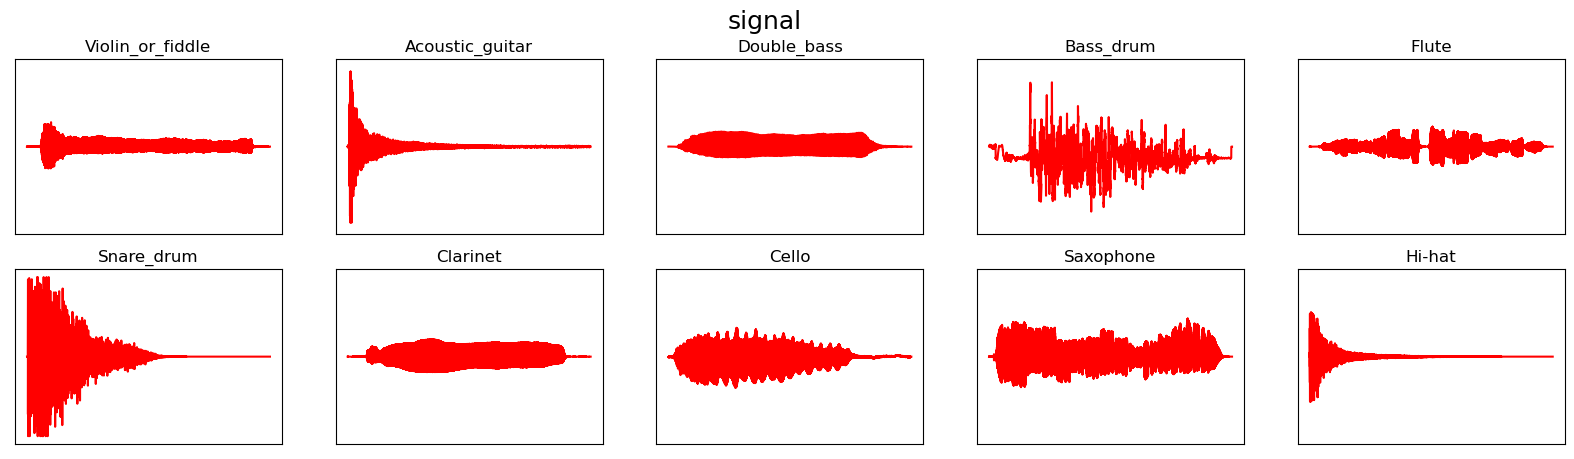

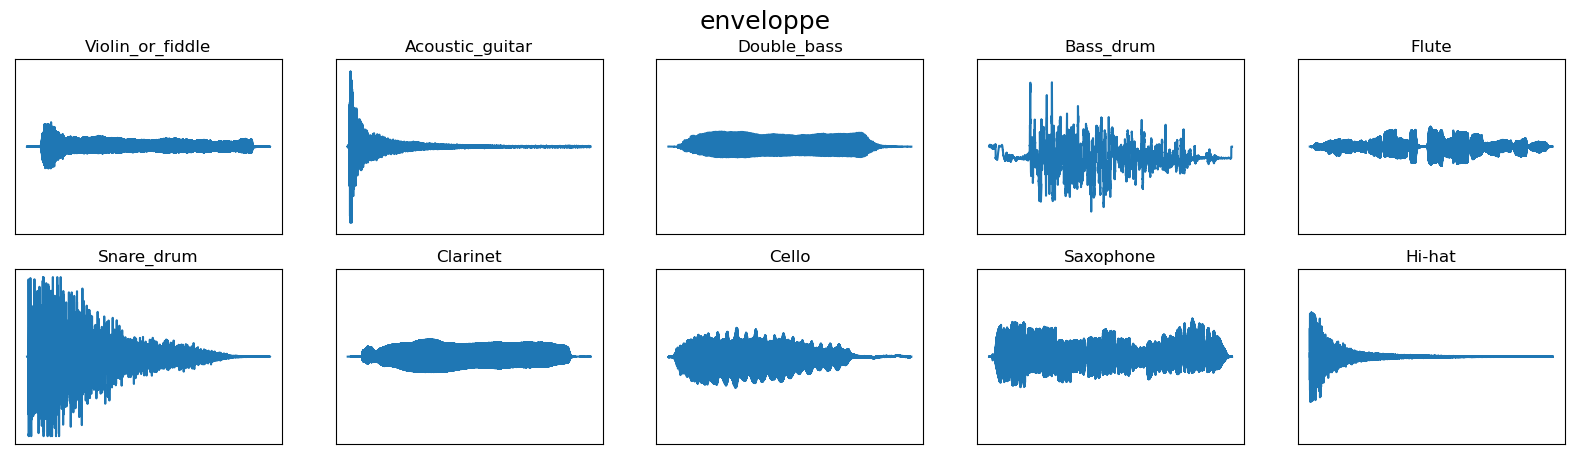

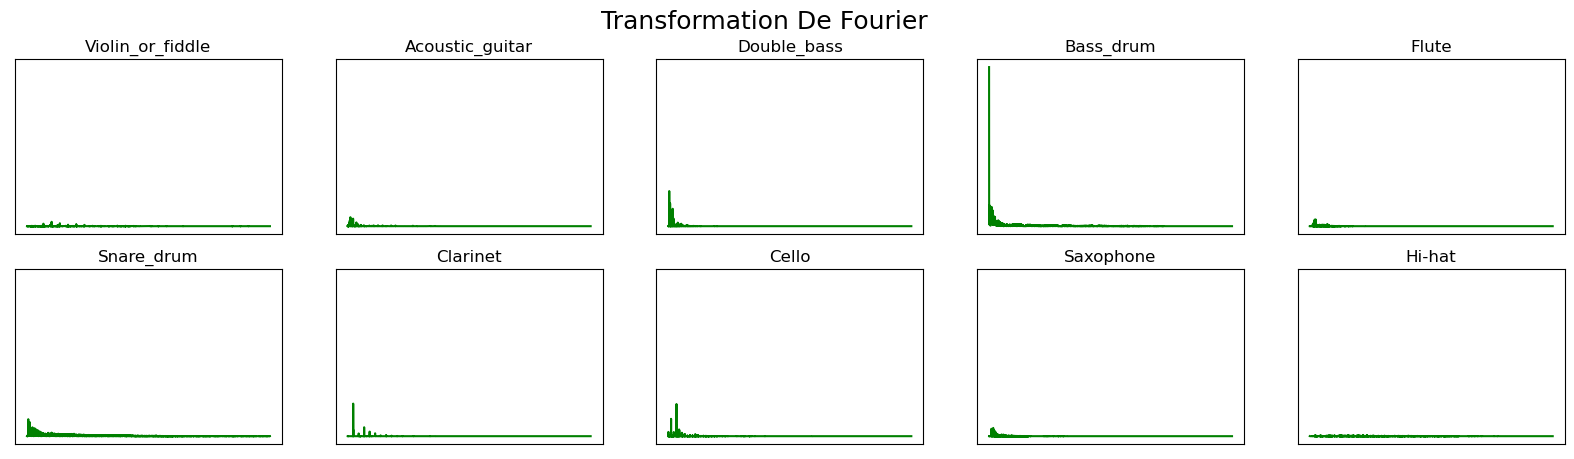

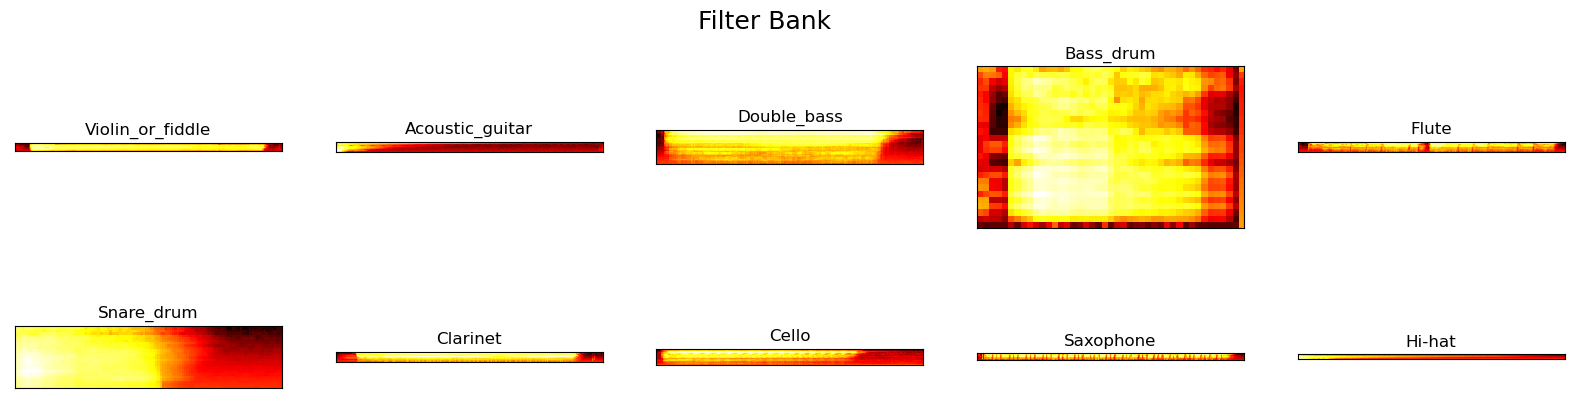

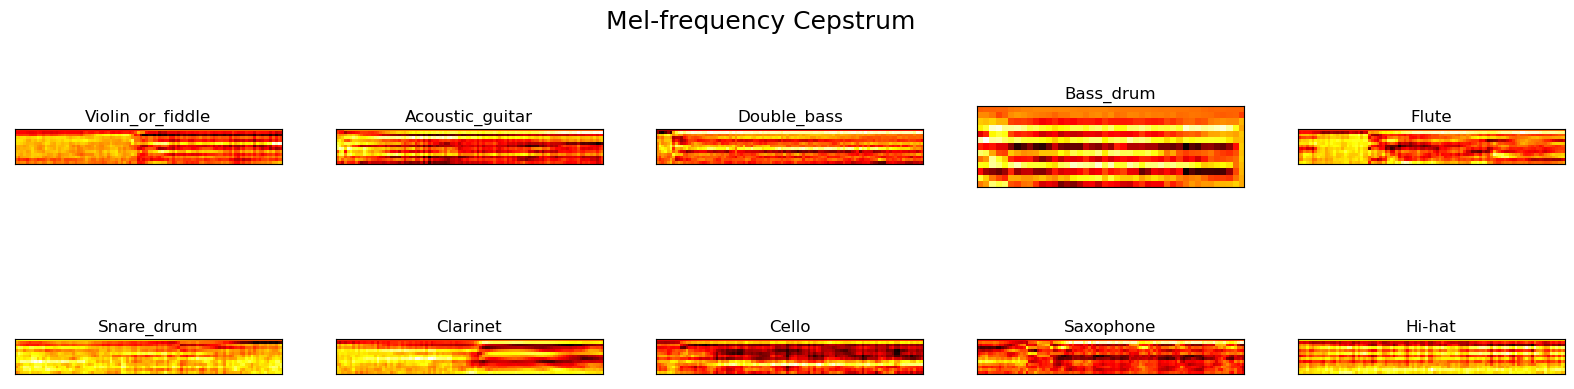

In [247]:
signals,fast_fourier_transform,filter_bank,mel_cepstrum=extract_features()
plot(signals,"signal")
plot(signals,"enveloppe")
plot(fast_fourier_transform,'fft')
plot(filter_bank,'fbank')
plot(mel_cepstrum,'')

# 3) traitement des données 

In [224]:
# creer dossier pour sauvegarder les données traités 
if not os.path.exists(output_path+"clean"):
    os.mkdir(output_path+"clean")
if not os.path.exists(output_path+"echantillion"):
    os.mkdir(output_path+"echantillion")
if not os.path.exists(output_path+"model"):
    os.mkdir(output_path+"model")
if not os.path.exists(output_path+"/model/cnn"):
    os.mkdir(output_path+"/model/cnn")
if not os.path.exists(output_path+"/model/lstm"):
    os.mkdir(output_path+"/model/lstm")

### nettoyage 

In [225]:
#nettoyer et enregistrer tous les signals nettoyées 
def nettoyer(choix):
    #sous echantillionnage on reduit la frequence pour creer des données plus compactes 
    rate=16000
    
    for i in tqdm(range(df.shape[0])):
        file=df['fname'][i]
        if choix==1:
            signal,_=librosa.load(os.path.join(input_path,'freesound-audio-tagging/audio_train',file),sr=rate)
            clean=signal_envelope(signal,rate,0.0005)
            wavfile.write(os.path.join(output_path,'clean',file),rate=rate,data=clean)
        elif choix==2:
            rate,signal=wavfile.read(os.path.join(output_path,'clean',file))
        #mise a jour de longueur apres nettoyage 
        df.loc[i,"longueur"]=signal.shape[0]/rate
    return(df)

### echantillionnage

les données audio sont differentes des autres données car elles sont echantillionné frequemment c'est pour cela qu'on va proceder de la façon suivante :
1) on va fixer une taille de fenetre = 0.1 s

2) on va esseyer de reduire la taille de données pour l'entrainement tout en gardant la meme distibution de probabilités pour les differents instriments (meme proportion de taille de données pour chaque instrument):
    
    a) on va effectuer `nb_tirage=longueur_totale/0.1` tirages aleatoires suivant les probabilités initiales .
    
    b) on extrait une fenetre de taille 0.1 s de chaque tirage ce qui correspond a `rate/10` en données 

quantité finale de données = quantité de données initale 
mais avec des signals de longueur 0.1 s 

In [226]:
def creer_X_y(long_fenetre=int(44100/10)):
    X_y=pd.DataFrame(columns=['file','signal','label','label_id'])
    #initialiser mini et max a  -inf et +inf
    mini,maxi=float('inf'),-float('inf')
    for i in tqdm(range(taille_echantillion)):
        #tirage aleatoire d'un label=instrument suivant probabilité initale 
        label_ =np.random.choice(label_dist.index,p=prob_dist)
        #choisir un fichier aleatoirement (uniforme) parmis les fichier du label tiré
        file=np.random.choice(df[df['label']==label_]['fname']) 
        #lire le fichier tirée 
        rate_,signal_=wavfile.read(os.path.join(output_path,'clean',file))
        if signal_.shape[0]<long_fenetre:
            continue
        #choisir fenetre aleatoire dans le signal:        
        debut_fenetre=np.random.randint(0,signal_.shape[0]-long_fenetre)
        #extraire la fenetre
        fenetre=signal_[debut_fenetre:debut_fenetre+long_fenetre]
        wavfile.write(os.path.join(output_path,'echantillion',str(i)+".wav"),rate=rate,data=fenetre)
        #calculer mfcc
        x=mfcc(fenetre,rate_).T
        
        mini=min(np.amin(x),mini)
        maxi=max(np.amax(x),maxi)
        X_y.loc[i,"file"]=str(i)+".wav"
        X_y.loc[i,"signal"]=x
        X_y.loc[i,"label"]=label_
        X_y.loc[i,"label_id"]=list(instruments).index(label_)
    return(X_y,mini,maxi)

In [227]:
#en lisant les données sauvegarder (output de mfcc ) qui sont initialement des np.array  on se trouve avec des chaine de caracteres '[['123','457'],['789','898']]' 
#cette fonction permet de transformer ces deriers en array
def transform(matrice):
    import re 
    X=[]
    matrice=matrice.replace('\n ','').replace("[[",'').replace(']]','').split('][')
    for i in range(len(matrice)):    
        L=re.sub(r'\s+', ' ', matrice[i])
        L=L.strip().split(' ')

        for k in range(len(L)):
            L[k]=float(L[k])
        X.append(L)
    return(np.array(X))

In [228]:
def echantillionnage(choix):
    if choix==1:
        Xy,mini,maxi=creer_X_y()
        #split X_y
        X=np.array(Xy.signal.values.tolist())
        y=np.array(Xy.label_id.values.tolist())

        #normaliser X
        X=(X-mini)/(maxi-mini)
        #save dataframe
        Xy['signal']=list(X)
        Xy.to_csv(os.path.join(output_path,"echantillion.csv"),index=False)
        pd.DataFrame({"mini":[mini],"maxi":[maxi]}).to_csv('/kaggle/working/minmax.csv',index=False)
        #transformer Y a une variable categorique(hot_encoding)
    elif choix==2:
        Xy=pd.read_csv(os.path.join(output_path,"echantillion.csv"))
        Xy.signal=Xy.signal.map(lambda x:transform(x))
        #split X_y
        X=np.array(Xy.signal.values.tolist())
        y=np.array(Xy.label_id.values.tolist())
    y_one_hot=to_categorical(y,num_classes=10)
    return(Xy,X,y,y_one_hot)

# 4) models

La méthode de descente de gradient utilise des poids pour ajuster les paramètres d'un modèle en fonction des erreurs de prédiction. Les poids peuvent être ajustés en utilisant des techniques telles que le calcul des poids de classe pour traiter les déséquilibres de classe dans les données d'entraînement.

Les poids de classe sont utilisés pour donner plus d'importance aux classes qui ont moins d'exemples dans les données d'entraînement. 

En utilisant des poids de classe, vous pouvez éviter que le modèle ne surprenne les classes qui ont plus d'exemples et ne prédise correctement que ces classes, ce qui peut entraîner une performance inférieure pour les classes moins représentées.

Il existe plusieurs façons de calculer les poids de classe, mais l'une des méthodes les plus courantes est de les calculer en utilisant la fréquence inverse de la classe. Cela signifie que le poids d'une classe est inversément proportionnel à la fréquence de cette classe dans les données d'entraînement.

### CNN

In [229]:
def conv(X):
    #sample n,features,Time Steps
    conv_input=X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
    model=Sequential()
    model.add(Conv2D(16,(3,3),activation='relu',
                    strides=(1,1),padding="same",input_shape=conv_input[0].shape))
    model.add(Conv2D(32,(3,3),activation='relu',
                     strides=(1,1),padding="same"))
    model.add(Conv2D(64,(3,3),activation='relu',
                     strides=(1,1),padding="same"))
    model.add(Conv2D(128,(3,3),activation='relu',
                     strides=(1,1),padding="same"))

    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())

    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))

    model.add(Dense(10,activation='softmax'))#classification, n_class=10 
    model.summary()
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])
    return (conv_input,model)

### LSTM

In [230]:
def lstm(X):
    #input shape: sample n,Time Steps,features
    X_lstm=[]
    for x in X:
        X_lstm.append(x.T)
    X_lstm=np.array(X_lstm)
    
    model=Sequential()
    #LSTRM input shape n,time=9,feat=13
    model.add(LSTM(128,return_sequences=True,input_shape=X_lstm[0].shape))
    model.add(LSTM(128,return_sequences=True))
    model.add(Dropout(0.5))

    model.add(TimeDistributed(Dense(64,activation='relu')))
    model.add(TimeDistributed(Dense(32,activation='relu')))
    model.add(TimeDistributed(Dense(16,activation='relu')))
    model.add(TimeDistributed(Dense(8,activation='relu')))

    model.add(Flatten())
    model.add(Dense(10,activation='softmax'))

    model.summary()
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])
    return(X_lstm,model)

### Evaluation

In [231]:
def evaluation(model,history,X_test,y_test): 
    from sklearn.metrics import f1_score, confusion_matrix, classification_report,ConfusionMatrixDisplay
    from sklearn.model_selection import learning_curve,cross_val_score

    if model!=None:
        y_pred_flat=np.argmax(model.predict(X_test),axis=-1)
        y_test_flat=np.argmax(y_test,axis=-1)

        disp = ConfusionMatrixDisplay.from_predictions(
                                                  y_test_flat,
                                                  y_pred_flat, 
                                                  display_labels=instruments, 
                                                  cmap=plt.cm.Reds
                                                  )
        fig = disp.figure_
        fig.set_figwidth(7)
        fig.set_figheight(7)
        plt.xticks(rotation=90)
        fig.suptitle('matrice de confusion')
        plt.show()

    plt.figure(figsize=(10,7))
    plt.subplot(1, 2,1)
    plt.plot(history['loss'], 'b-', label='train loss')
    plt.plot(history['val_loss'], 'r-', label='val loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1,2, 2)
    plt.plot(history['acc'], 'b-', label='train accuracy')
    plt.plot(history['val_acc'], 'r-', label='val accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

### Entrainement d'un modèle

In [ ]:
def entrainer_model(choix,X,y,y_one_hot,epochs=20):
    poids_classe=compute_class_weight(class_weight='balanced',classes=np.unique(y),y=y)
    poids_classe={i:poids_classe[i] for i in range(len(poids_classe)) }
    if choix==1:
        X_,model=conv(X)
    elif choix==2:
        X_,model=lstm(X)
    X_train, X_test, y_train, y_test = train_test_split(X_, y_one_hot, test_size=0.2, random_state=7)
    
    #Early stopping pour eviter le sur-apprentissage 
    callback = EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)
    
    hist=model.fit(X_train,y_train,epochs=epochs,class_weight=poids_classe,validation_data=(X_test,y_test),callbacks=callback)
    history=pd.DataFrame(hist.history)
    if choix==1:
        #enregistrer history
        history.to_csv(os.path.join(output_path,'model/cnn/history_cnn.csv'),index=False)
        # enregistrer le model
        model.save(os.path.join(output_path,'model/cnn/cnn.h5'))
    elif choix==2:
        #enregistrer le model
        history.to_csv(os.path.join(output_path,'model/lstm/history_lstm.csv'),index=False)
        # enregistrer the weights
        model.save(os.path.join(output_path,'model/lstm/lstm.h5'))
    evaluation(model,history,X_test,y_test)
    return(model,history)

### importation du modèle enregistré

In [236]:
def load_model(choix):
    if choix==1:
        model=tf.keras.models.load_model(os.path.join(output_path,'model/cnn/cnn.h5'))
        history=pd.read_csv(os.path.join(output_path,'model/cnn/history_cnn.csv'))
    elif choix==2:
        model=tf.keras.models.load_model(os.path.join(output_path,'model/lstm/lstm.h5'))
        history=pd.read_csv(os.path.join(output_path,'model/lstm/history_lstm.csv'))
    return(model,history)

### validation du modèle

In [252]:
def validation(model,choix_model):
    rate=16000
    #recuperer le mini et maxi(enregistrés lors de la creation de X_y) pour transformation du fichiers
    minmax=pd.read_csv(os.path.join(output_path,'minmax.csv'))
    mini=minmax["mini"].values[0]
    maxi=minmax["maxi"].values[0]
    df_val=pd.read_csv(os.path.join(input_path,"freesound-audio-tagging/test_post_competition.csv"))
    #supprimer "manually_verified" qui est inutile
    df_val.drop(columns=['usage',"freesound_id","license"],inplace=True)
    #selectionner les labels des instruments seulements
    df_val=df_val[df_val["label"].isin(instruments)]
    df_val.reset_index(drop=True,inplace=True)
    df_val.head(3)
    df_prediction=pd.DataFrame(columns=["fichier"]+list(instruments)+["y_pred","y_true"])
    print("Extraction des features a partir des audios")
    for i in tqdm(range(20)):
        file=df_val["fname"][i]
        signal,_=librosa.load(os.path.join(input_path,"freesound-audio-tagging/audio_test",file),sr=rate)
        signal=signal_envelope(signal,rate,0.0005)
        #choisir fenetre aleatoire dans le signal: 
        label=df_val["label"][i]
        label_id=list(instruments).index(label)
        y_probs=[]
        for k in range(0,len(signal)-int(44100/10),int(44100/10)):
            fenetre=signal[k:k+int(44100/10)]
            x=mfcc(fenetre,rate).T
            if choix_model==2: x=x.T
            x=(x-mini)/(maxi-mini)
            x=x.reshape(1,x.shape[0],x.shape[1],1)
            y_probs.append(instruments[np.argmax(model.predict(x,verbose=0))])
        y_probs=np.vstack(y_probs).flatten()
        y_probs=pd.Series(y_probs).value_counts()
        y_probs=(y_probs/y_probs.sum()).round(2)
        #fichier
        df_prediction.loc[i,"fichier"]=file
        #y_true
        df_prediction.loc[i,"y_true"]=label
        #prob par insturments
        df_prediction.loc[i,instruments]=0
        df_prediction.loc[i,y_probs.keys()]=y_probs.values
        #y_pred
        df_prediction.loc[i,"y_pred"]=y_probs.idxmax()
    return(df_prediction)

# Main

avec cette fonction vous pouvez choisir de : 
* importer des données sauvegarder et pretraités ou effectuer un nouveau traitement ( nettoyage & echatillionnage )

* entrainer le model ou importer un model sauvegardé 

In [259]:
def main():
    choix=int(input("- Pour entrainer un modele 1\n"
                     "- Pour importer un modele entrainé 2 \n"))
    choix_model=int(input("choix du model :\n"
                        "- CNN 1\n"
                        "- LSTM 2\n"))
    if choix==2:
        model,history=load_model(choix_model)
        model.summary()
        print(history)
        evaluation(None,history,_,_)

    elif choix==1:
        #si je multiplie la taille_echantillion par 2 ou 3 je vais avoir des meilleurs resultat(~ augmantation de 2% au niveau des mesures) mais cela va prendre 1h de 
        #de plus pour l'echantillionnage 
        df,instruments=import_data(input_path)


        longueur_totale=df["longueur"].sum()
        taille_echantillion=int(longueur_totale.sum( )/0.1)
        rate=16000
        choix_data=int(input("- pour nettoyer et sauvegarder des nouveaux signiaux 1\n"  
                             "- pour importer des signaux traités déja 2\n"))
        
        
        #nettoyage
        if choix_data==1:print('\n** nettoyage **\n')
        df=nettoyer(choix_data)

        #echantillionnage
        if choix_data==1:print('\n** echantillionage **\n')
        Xy,X,y,y_one_hot=echantillionnage(choix_data)
        print("\n**entrainement du modele**\n")
        history,model=entrainer_model(choix_model,X,y,y_one_hot)
    return(validation(model,choix_model))


- Pour entrainer un modele 1
- Pour importer un modele entrainé 2 
2
choix du model :
- CNN 1
- LSTM 2
1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 13, 27, 16)        160       
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 27, 32)        4640      
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 27, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 27, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 13, 128)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dro

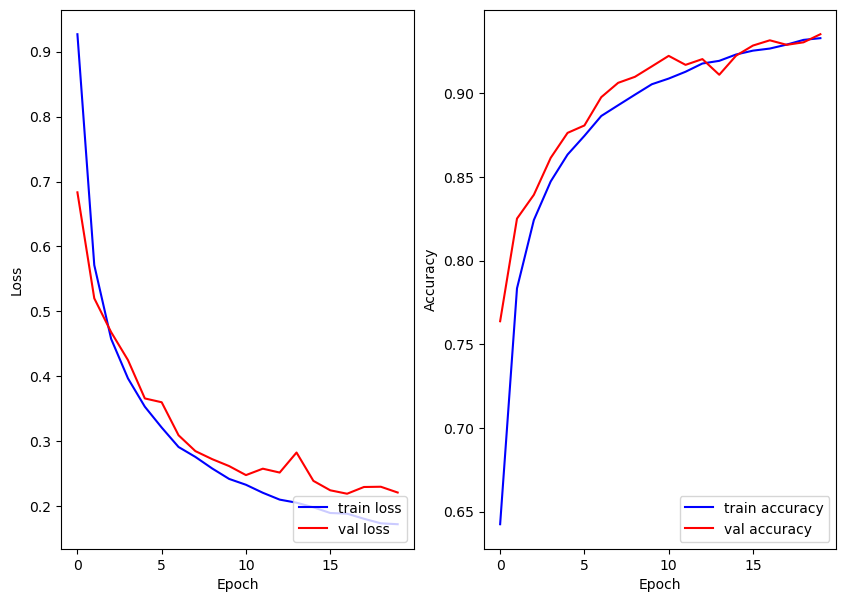

Extraction des features a partir des audios


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  1.53s/it]


,fichier,Violin_or_fiddle,Acoustic_guitar,Double_bass,Bass_drum,Flute,Snare_drum,Clarinet,Cello,Saxophone,Hi-hat,y_pred,y_true
0,0038a046.wav,0,0,0,0.4,0,0.4,0,0.2,0,0,Bass_drum,Bass_drum
1,007759c4.wav,0,0,0,0,0.69,0,0.19,0,0.11,0,Flute,Saxophone
2,008afd93.wav,0,0,0,0,0,0,0,0,1.0,0,Saxophone,Saxophone
3,01bb344f.wav,0,0.29,0.29,0,0,0,0,0,0.43,0,Saxophone,Acoustic_guitar
4,023eab1f.wav,0,0,1.0,0,0,0,0,0,0,0,Double_bass,Double_bass
5,028db587.wav,0,0,1.0,0,0,0,0,0,0,0,Double_bass,Double_bass
6,03319789.wav,1.0,0,0,0,0,0,0,0,0,0,Violin_or_fiddle,Violin_or_fiddle
7,0381efd3.wav,0,0,1.0,0,0,0,0,0,0,0,Double_bass,Double_bass
8,0459ee65.wav,0,0,0,0,0.21,0,0.79,0,0,0,Clarinet,Clarinet
9,047bf19c.wav,0,0,0,0,0.88,0,0,0.12,0,0,Flute,Flute


In [260]:
main()

- Pour entrainer un modele 1
- Pour importer un modele entrainé 2 
2
choix du model :
- CNN 1
- LSTM 2
2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 27, 128)           72704     
                                                                 
 lstm_1 (LSTM)               (None, 27, 128)           131584    
                                                                 
 dropout (Dropout)           (None, 27, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 27, 64)           8256      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 27, 32)           2080      
 tributed)                                                       
                 

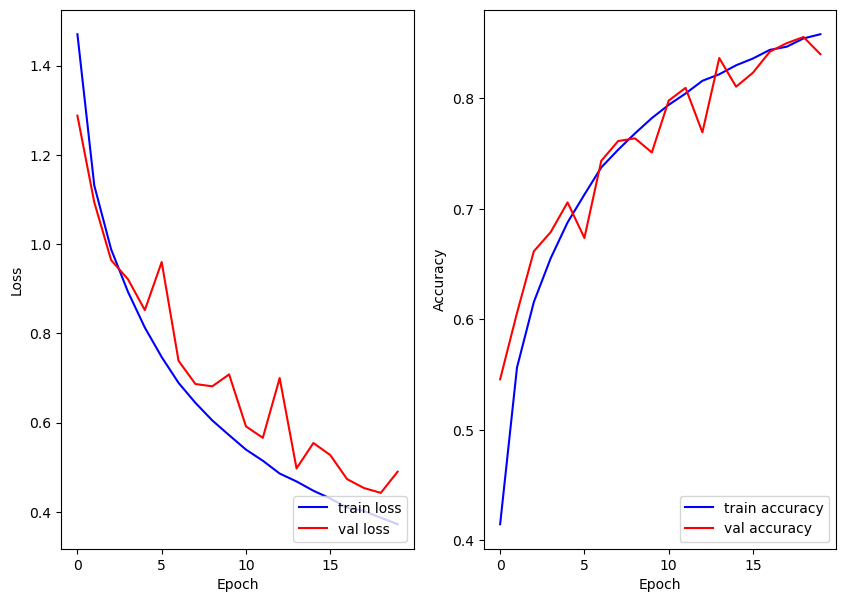

Extraction des features a partir des audios


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:35<00:00,  1.76s/it]


,fichier,Violin_or_fiddle,Acoustic_guitar,Double_bass,Bass_drum,Flute,Snare_drum,Clarinet,Cello,Saxophone,Hi-hat,y_pred,y_true
0,0038a046.wav,0,0,0,0.6,0,0,0,0,0.4,0,Bass_drum,Bass_drum
1,007759c4.wav,0,0,0,0,0.97,0,0,0,0.03,0,Flute,Saxophone
2,008afd93.wav,0.07,0,0.03,0,0.07,0.03,0,0,0.79,0,Saxophone,Saxophone
3,01bb344f.wav,0.14,0.43,0.29,0,0.14,0,0,0,0,0,Acoustic_guitar,Acoustic_guitar
4,023eab1f.wav,0,0,1.0,0,0,0,0,0,0,0,Double_bass,Double_bass
5,028db587.wav,0,0,1.0,0,0,0,0,0,0,0,Double_bass,Double_bass
6,03319789.wav,1.0,0,0,0,0,0,0,0,0,0,Violin_or_fiddle,Violin_or_fiddle
7,0381efd3.wav,0,0,1.0,0,0,0,0,0,0,0,Double_bass,Double_bass
8,0459ee65.wav,0,0,0,0,0.16,0,0.84,0,0,0,Clarinet,Clarinet
9,047bf19c.wav,0,0,0,0,0.12,0,0.88,0,0,0,Clarinet,Flute


In [261]:
main()

# 5) comparaison 

In [262]:
def comparaison(): 
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    hist_conv=pd.read_csv(os.path.join(output_path,'model/cnn/history_cnn.csv')) 
    hist_lstm=pd.read_csv(os.path.join(output_path,'model/lstm/history_lstm.csv')) 
    plt.plot(hist_conv['loss'],label='train loss conv')
    plt.plot(hist_lstm['loss'],label='train loss lstm')
    plt.legend(loc='lower right')
    plt.subplot(1,2,2)

    plt.plot(hist_conv['acc'],label='train acc conv')
    plt.plot(hist_lstm['acc'],label='train acc lstm')
    plt.legend(loc='lower right')
    plt.show()

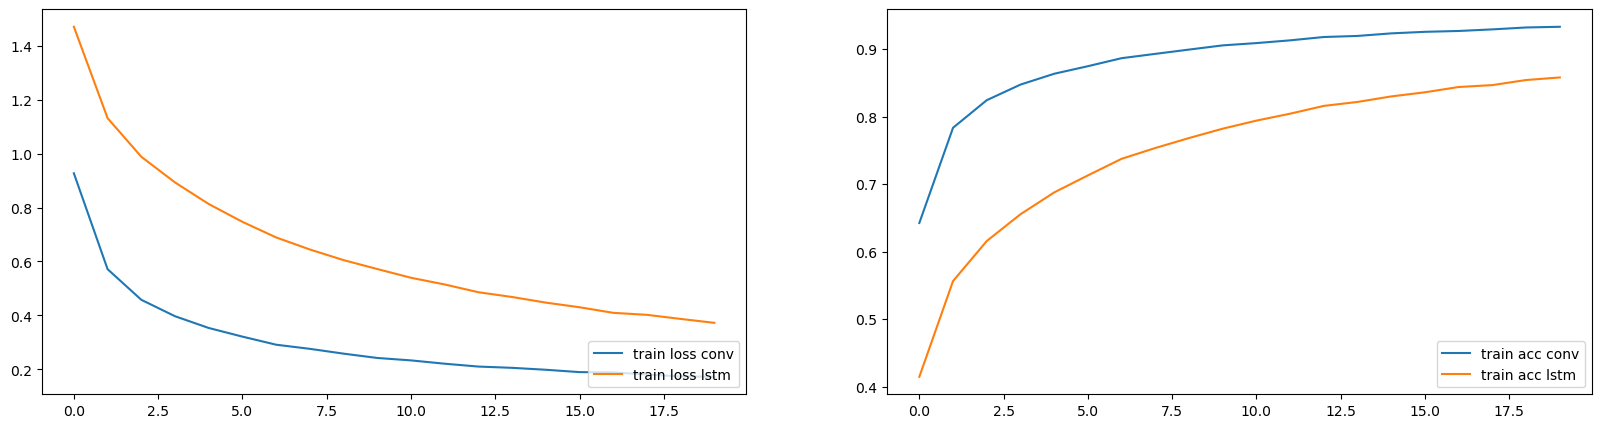

In [263]:
comparaison()

CNN était a 61% après la première époque qui a durée 24s et 92.4% a la derniere epoque
 
LSTM était a 38%% aprés la premiere époque qui a durée 39s et 
 
•Meilleurs résultats avec CNN cela peut s’expliquer par la différence de nombre de paramètres lstm=216018 > CNN= 449402

•CNN est aussi plus rapide que LSTM. 
